<a href="https://colab.research.google.com/github/ZenaNBamboat/MMAI5100_Applications_of_neural_networks/blob/main/MMAI5500_Assignment2_ZenaNozarBamboat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMAI 5500 Assignment 2 - DIY Candy Counter

**Name:** Zena Nozar Bamboat

## Assignment Overview
This notebook fine-tunes a DETR (Detection Transformer) object detection model to count 8 types of candy:
- Moon, Insect, Black_star, Grey_star, Unicorn_whole, Unicorn_head, Owl, Cat

## Dataset
- **Images:** 11 images (9 train, 2 test)
- **Format:** COCO JSON annotations
- **Files used:**
  - `MMAI5500_Assignment2.zip` (labeled images)
  - `result.json` (COCO annotations)

## Model
- **Training:** 80 epochs
- **Final Loss:** Training: 1.18, Validation: 1.23
- **Saved Model:** `candy_detector/`

In [1]:
# ============================================================================
# CELL 1: Install libraries and setup
# ============================================================================
!pip install -q pillow torch torchvision transformers datasets accelerate pycocotools

import os
os.environ["WANDB_DISABLED"] = "true"

from google.colab import files
import zipfile

print("Please upload your MMAI5500_Assignment2.zip file")
uploaded = files.upload()

for filename in uploaded.keys():
    if filename.endswith('.zip'):
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall('.')
        print(f"Extracted {filename}")

Please upload your MMAI5500_Assignment2.zip file


Saving MMAI5500_Assignment2.zip to MMAI5500_Assignment2.zip
Extracted MMAI5500_Assignment2.zip


In [2]:
# ============================================================================
# CELL 2: Imports and verification
# ============================================================================
import json
import random
import shutil
from pathlib import Path
import numpy as np
import torch
from PIL import Image
from datasets import load_dataset
from transformers import AutoImageProcessor, AutoModelForObjectDetection, TrainingArguments, Trainer, pipeline

print("Torch:", torch.__version__)
print("Transformers:", __import__('transformers').__version__)
print("CUDA:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

Torch: 2.8.0+cu126
Transformers: 4.57.1
CUDA: True
GPU: Tesla T4


In [4]:
# ============================================================================
# CELL 3: Setup paths and constants
# ============================================================================
# Auto-detect the extracted folder name
possible_dirs = ["MMAI5500_Assignment2", "MMAI5500_Assignment_2_Main", "MMAI5500_Assignment_2", "data"]
RAW_DIR = None

for dir_name in possible_dirs:
    if Path(dir_name).exists():
        RAW_DIR = Path(dir_name)
        break

if RAW_DIR is None:
    # List all directories to help debug
    print("Available directories:")
    for p in Path(".").iterdir():
        if p.is_dir():
            print(f"  - {p}")
    raise FileNotFoundError("Could not find extracted data directory")

COCO_JSON = RAW_DIR / "result.json"
IMAGES_DIR = RAW_DIR / "images"

print(f"Using directory: {RAW_DIR}")
assert COCO_JSON.exists(), f"Missing {COCO_JSON}"
assert IMAGES_DIR.exists(), f"Missing {IMAGES_DIR}"

CANDY_ID2LABEL = {
    1: "Moon", 2: "Insect", 3: "Black_star", 4: "Grey_star",
    5: "Unicorn_whole", 6: "Unicorn_head", 7: "Owl", 8: "Cat"
}
CANDY_LABEL2ID = {v: k for k, v in CANDY_ID2LABEL.items()}

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

print("Setup complete!")
print(f"Found {len(list(IMAGES_DIR.glob('*.jpg')))} images")

Using directory: MMAI5500_Assignment2
Setup complete!
Found 11 images


In [5]:
# ============================================================================
# CELL 4: Convert COCO to HuggingFace format with 80/20 split
# ============================================================================
with open(COCO_JSON) as f:
    coco = json.load(f)

# Filter to only the 8 required classes
allowed = set(CANDY_LABEL2ID.keys())
coco_id2name = {c["id"]: c["name"] for c in coco["categories"]}
id_remap = {oid: CANDY_LABEL2ID[nm] for oid, nm in coco_id2name.items() if nm in allowed}

# Group annotations by image
ann_by_img = {}
for ann in coco["annotations"]:
    if ann["category_id"] in id_remap:
        a = dict(ann)
        a["category_id"] = id_remap[a["category_id"]]
        ann_by_img.setdefault(a["image_id"], []).append(a)

# Create HuggingFace format items
hf_items = []
for img in coco["images"]:
    entry = {
        "file_name": Path(img["file_name"]).name,
        "image_id": img["id"],
        "height": img["height"],
        "width": img["width"],
        "objects": {"bbox": [], "category": [], "area": [], "id": []}
    }
    for a in ann_by_img.get(img["id"], []):
        entry["objects"]["bbox"].append(a["bbox"])
        entry["objects"]["category"].append(int(a["category_id"]))
        entry["objects"]["area"].append(a.get("area", float(a["bbox"][2] * a["bbox"][3])))
        entry["objects"]["id"].append(a["id"])
    hf_items.append(entry)

# Stratified split by dominant class
def dominant_class(objs):
    cats = objs["category"]
    if not cats:
        return 0
    v, c = np.unique(cats, return_counts=True)
    return int(v[c.argmax()])

buckets = {}
for i, it in enumerate(hf_items):
    buckets.setdefault(dominant_class(it["objects"]), []).append(i)

idx_train, idx_test = [], []
for s, l in buckets.items():
    k = int(round(0.8 * len(l)))
    random.shuffle(l)
    idx_train += l[:k]
    idx_test += l[k:]

# Create directory structure
DATA_DIR = Path("data")
TRAIN_DIR = DATA_DIR / 'train'
TEST_DIR = DATA_DIR / 'test'

if DATA_DIR.exists():
    shutil.rmtree(DATA_DIR)

TRAIN_DIR.mkdir(parents=True)
TEST_DIR.mkdir(parents=True)

def write_split(ids, d):
    for i in ids:
        f = hf_items[i]["file_name"]
        src = IMAGES_DIR / f
        dst = d / f
        if not dst.exists():
            shutil.copy2(src, dst)
    with open(d / 'metadata.jsonl', 'w') as f:
        for i in ids:
            f.write(json.dumps(hf_items[i]) + '\n')

write_split(idx_train, TRAIN_DIR)
write_split(idx_test, TEST_DIR)

print(f'Train: {len(idx_train)} images')
print(f'Test: {len(idx_test)} images')

Train: 9 images
Test: 2 images


In [6]:
# ============================================================================
# CELL 5: Load dataset
# ============================================================================
candy_ds = load_dataset("imagefolder", data_dir="data")
print(candy_ds)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'height', 'width', 'objects'],
        num_rows: 9
    })
    test: Dataset({
        features: ['image', 'image_id', 'height', 'width', 'objects'],
        num_rows: 2
    })
})


In [15]:
# ============================================================================
# CELL 6: Setup image processor and transforms
# ============================================================================
MODEL = "facebook/detr-resnet-50"
proc = AutoImageProcessor.from_pretrained(MODEL)

def flip_boxes(boxes, img_width):
    return [[img_width - (x + w), y, w, h] for x, y, w, h in boxes]

def prep(examples):
    imgs, anns = [], []

    # Handle both single item and batch
    images = examples["image"] if isinstance(examples["image"], list) else [examples["image"]]
    objects = examples["objects"] if isinstance(examples["objects"], list) else [examples["objects"]]
    splits = examples.get("__split__", [""] * len(images))
    if not isinstance(splits, list):
        splits = [splits]

    for img, objs, split in zip(images, objects, splits):
        # Convert to PIL if needed
        if hasattr(img, 'convert'):
            im = img.convert("RGB")
        else:
            im = Image.open(img["path"]).convert("RGB")

        b = objs["bbox"]
        c = objs["category"]
        a = objs.get("area", [])

        # Calculate area if missing
        if not a or len(a) != len(b):
            a = [float(box[2] * box[3]) for box in b]

        # Data augmentation: horizontal flip for training
        if split == "train" and len(b) > 0 and random.random() < 0.5:
            w, h = im.size
            im = im.transpose(Image.FLIP_LEFT_RIGHT)
            b = flip_boxes(b, w)

        imgs.append(im)
        anns.append({
            "image_id": 0,
            "annotations": [
                {
                    "bbox": bb,
                    "category_id": int(cc),
                    "area": float(ar),
                    "iscrowd": 0,
                    "id": idx
                }
                for idx, (bb, cc, ar) in enumerate(zip(b, c, a))
            ]
        })

    return proc(images=imgs, annotations=anns, return_tensors="pt")

def tag(x, n):
    x["__split__"] = n
    return x

# Apply map to each split separately
candy_ds["train"] = candy_ds["train"].map(lambda x: tag(x, "train"))
candy_ds["test"] = candy_ds["test"].map(lambda x: tag(x, "test"))

train_ds = candy_ds["train"].with_transform(prep)
test_ds = candy_ds["test"].with_transform(prep)

print("Data preprocessing configured")

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

Data preprocessing configured


In [17]:
# ============================================================================
# CELL 7: Load model
# ============================================================================
num_labels = len(CANDY_ID2LABEL)
model = AutoModelForObjectDetection.from_pretrained(
    MODEL,
    num_labels=num_labels,
    id2label=CANDY_ID2LABEL,
    label2id=CANDY_LABEL2ID,
    ignore_mismatched_sizes=True
)

print(f"Model loaded: {MODEL}")
print(f"Number of classes: {num_labels}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

Model loaded: facebook/detr-resnet-50
Number of classes: 8


In [21]:
# ============================================================================
# CELL 8: Define collate function
# ============================================================================
def collate_fn(batch):
    pixel_values = torch.stack([x["pixel_values"] for x in batch])
    labels = [x["labels"] for x in batch]
    return {"pixel_values": pixel_values, "labels": labels}

print("Collate function defined")

Collate function defined


In [22]:
# ============================================================================
# CELL 9: Training configuration (80 epochs)
# ============================================================================
args = TrainingArguments(
    output_dir="candy_detector_output",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=80,
    learning_rate=5e-5,
    weight_decay=1e-4,
    eval_strategy="epoch",  # Changed from evaluation_strategy
    save_strategy="epoch",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=3,
    remove_unused_columns=False,
    fp16=torch.cuda.is_available(),
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=proc,
    data_collator=collate_fn,
)

print("Trainer configured!")
print(f"Training for {args.num_train_epochs} epochs")
print(f"Logging every {args.logging_steps} steps")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Trainer configured!
Training for 80 epochs
Logging every 10 steps


/tmp/ipython-input-3133314774.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [23]:
# ============================================================================
# CELL 10: Train the model
# ============================================================================
print("Starting training...")
print("This will take approximately 30-40 minutes for 80 epochs")
print("Watch the loss decrease to confirm learning is happening!")
print("-" * 60)

train_results = trainer.train()

print("-" * 60)
print("\nTraining completed!")
print(f"Final training loss: {train_results.training_loss:.4f}")

Starting training...
This will take approximately 30-40 minutes for 80 epochs
Watch the loss decrease to confirm learning is happening!
------------------------------------------------------------


Epoch,Training Loss,Validation Loss
1,No log,2.545031
2,2.830900,2.478860
3,2.830900,2.347151
4,2.466500,2.327167
5,2.466500,2.243856
6,2.329300,2.216973
7,2.329300,2.158256
8,2.184400,2.114284
9,2.184400,2.084477
10,2.083600,2.164103


------------------------------------------------------------

Training completed!
Final training loss: 1.6513


In [24]:
# ============================================================================
# CELL 11: Evaluate and save model
# ============================================================================
metrics = trainer.evaluate()
print("Final evaluation metrics:", metrics)

trainer.save_model("candy_detector")
proc.save_pretrained("candy_detector")

print("\nModel saved to 'candy_detector' directory!")

Final evaluation metrics: {'eval_loss': 1.2270057201385498, 'eval_runtime': 0.9976, 'eval_samples_per_second': 2.005, 'eval_steps_per_second': 1.002, 'epoch': 80.0}

Model saved to 'candy_detector' directory!


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas


Detections: 8 objects found
  - Grey_star: 0.491
  - Moon: 0.308
  - Grey_star: 0.429
  - Grey_star: 0.432
  - Grey_star: 0.551
  - Grey_star: 0.383
  - Moon: 0.411
  - Moon: 0.370


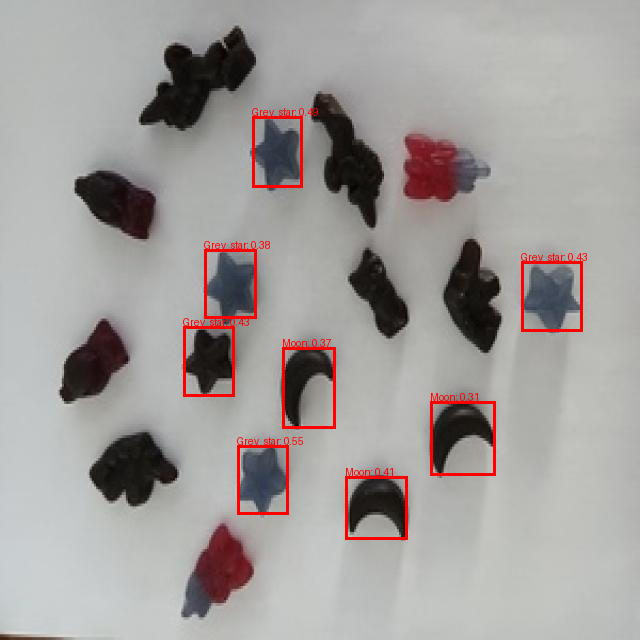

In [25]:
# ============================================================================
# CELL 12: Test with visualization
# ============================================================================
from PIL import ImageDraw

obj_detector = pipeline("object-detection", model="candy_detector")

# Get a test image
test_idx = 0
test_image_path = list(Path("data/test").glob("*.jpg"))[test_idx]
test_img = Image.open(test_image_path).convert("RGB")

# Run detection
detections = obj_detector(test_img, threshold=0.3)

print(f"\nDetections: {len(detections)} objects found")
for det in detections:
    print(f"  - {det['label']}: {det['score']:.3f}")

# Draw bounding boxes
draw_img = test_img.copy()
draw = ImageDraw.Draw(draw_img)

for detection in detections:
    box = detection['box']
    label = detection['label']
    score = detection['score']

    draw.rectangle(
        [(box['xmin'], box['ymin']), (box['xmax'], box['ymax'])],
        outline="red",
        width=3
    )

    draw.text(
        (box['xmin'], box['ymin'] - 10),
        f"{label}: {score:.2f}",
        fill="red"
    )

display(draw_img)

In [26]:
# ============================================================================
# CELL 13: Download model
# ============================================================================
!zip -r -q candy_detector.zip candy_detector/

from google.colab import files
files.download('candy_detector.zip')

print("Model downloaded!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model downloaded!


In [30]:
# Verification cell - checking model exists
import os
print(" candy_detector exists:", os.path.isdir("candy_detector"))
if os.path.isdir("candy_detector"):
    print("Model files:", os.listdir("candy_detector")[:10])
else:
    print("ERROR: candy_detector directory not found!")

 candy_detector exists: True
Model files: ['training_args.bin', 'model.safetensors', 'preprocessor_config.json', 'config.json']


In [27]:
# ============================================================================
# CELL 14: FINAL CELL - candy_counter function
# ============================================================================

import numpy as np
from PIL import Image
from transformers import pipeline

def candy_counter(image):
    """
    Count different types of candies in an image.

    Args:
        image: numpy array with shape (H, W, C) representing the input image

    Returns:
        dict: Dictionary with counts of each candy type
    """
    # Convert numpy array to PIL Image
    if isinstance(image, np.ndarray):
        if image.dtype != np.uint8:
            if image.max() <= 1.0:
                image = (image * 255).astype(np.uint8)
            else:
                image = image.astype(np.uint8)
        pil_image = Image.fromarray(image)
    else:
        pil_image = image

    # Load detector pipeline
    obj_detector = pipeline("object-detection", model="candy_detector")

    # Run detection
    detections = obj_detector(pil_image, threshold=0.3)

    # Initialize counts for all 8 candy types
    candy_counts = {
        'Moon': 0,
        'Insect': 0,
        'Black_star': 0,
        'Grey_star': 0,
        'Unicorn_whole': 0,
        'Unicorn_head': 0,
        'Owl': 0,
        'Cat': 0
    }

    # Count detections
    for detection in detections:
        label = detection['label']
        if label in candy_counts:
            candy_counts[label] += 1

    return candy_counts